In [1]:
import os
import numpy as np

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [2]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [3]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 315s 625ms/step - loss: 0.3730 - val_loss: 0.2918
Epoch 2/40
500/500 [==============================] - 358s 716ms/step - loss: 0.3180 - val_loss: 0.2833
Epoch 3/40
500/500 [==============================] - 353s 707ms/step - loss: 0.3117 - val_loss: 0.2804
Epoch 4/40
500/500 [==============================] - 362s 724ms/step - loss: 0.3077 - val_loss: 0.2782
Epoch 5/40
500/500 [==============================] - 354s 708ms/step - loss: 0.3045 - val_loss: 0.2803
Epoch 6/40
500/500 [==============================] - 351s 703ms/step - loss: 0.3006 - val_loss: 0.2762
Epoch 7/40
500/500 [==============================] - 361s 723ms/step - loss: 0.3010 - val_loss: 0.2743
Epoch 8/40
500/500 [==============================] - 359s 718ms/step - loss: 0.2995 - val_loss: 0.2757
Epoch 9/40
500/500 [==============================] - 350s 700ms/step - loss: 0.2956 - val_loss: 0.2748
Epoch 10/40
500/500 [==============================] - 359s 718m

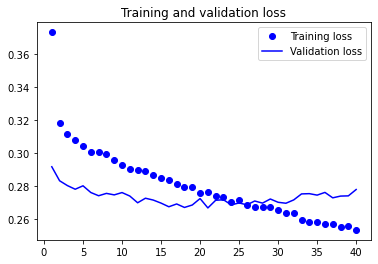

In [6]:
plot_loss(history)

In [7]:
model.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 148s 159ms/step - loss: 0.2951


0.29508480429649353

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0003), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=30, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/30
500/500 [==============================] - 380s 756ms/step - loss: 0.3282 - val_loss: 0.2880
Epoch 2/30
500/500 [==============================] - 389s 778ms/step - loss: 0.3080 - val_loss: 0.2819
Epoch 3/30
500/500 [==============================] - 392s 784ms/step - loss: 0.3025 - val_loss: 0.2816
Epoch 4/30
500/500 [==============================] - 387s 774ms/step - loss: 0.2959 - val_loss: 0.2797
Epoch 5/30
500/500 [==============================] - 373s 746ms/step - loss: 0.2923 - val_loss: 0.2757
Epoch 6/30
500/500 [==============================] - 371s 742ms/step - loss: 0.2900 - val_loss: 0.2833
Epoch 7/30
500/500 [==============================] - 389s 778ms/step - loss: 0.2860 - val_loss: 0.2697
Epoch 8/30
500/500 [==============================] - 385s 771ms/step - loss: 0.2822 - val_loss: 0.2657
Epoch 9/30
500/500 [==============================] - 370s 741ms/step - loss: 0.2791 - val_loss: 0.2668
Epoch 10/30
500/500 [==============================] - 384s 768m

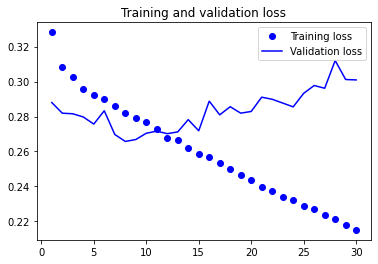

In [9]:
plot_loss(history)

In [10]:
model.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 167s 180ms/step - loss: 0.3238


0.32382485270500183